# Coming from TensorFlow to NengoDL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for people who are familiar with TensorFlow and looking to learn more about neuromorphic modelling with NengoDL.  For the other approach, users familiar with Nengo looking to learn how to use NengoDL, check out [this tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you would want to use it.  Nengo is a tool for constructing and simulating neural networks.  That is, to some extent, the same purpose as TensorFlow (and its higher level API, Keras).  For example, here is how we might build a simple two layer auto-encoder network in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net: 
    # input
    nengo_a = nengo.Node(np.zeros(n_in))
    
    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())
    
    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, 
        transform=nengo_dl.dists.Glorot())
    
    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and the creation of the connections between layers.  This is because the connection structure in Nengo networks often has a lot more state and general complexity than in typical deep learning networks, so it is helpful to be able to control it independently (we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we want to collect the activities of those neurons when the simulation is running.  You can think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality available, but we will focus on the features most familiar or relevant to those coming from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the Nengo-specific [documentation](https://www.nengo.ai/nengo/) and [examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.predict(np.ones((minibatch_size, n_in)));

Again, accomplishing the same thing in Nengo bears many similarities.  We create a `Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, 
                        minibatch_size=minibatch_size) as sim:
    sim.predict(np.ones((minibatch_size, 1, n_in)));

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

One difference you may note is the extra dimension with size 1 in the shape of the Nengo inputs.  This represents the time dimension; in this example we're only running for a single timestep, which is why it has size 1, but this could be used to provide different input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an abstract set of computations, in Nengo we (almost) always think of the graph as representing a stateful neural simulation, where values are accumulated, updated, and communicated over time.  This is not to say there is no overlap (we can create TensorFlow simulations that execute over time, and we can create Nengo simulations without temporal dynamics), but this is a different way of thinking about computations that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic networks include features drawn from biological neural networks, in an effort to understand or recreate the functionality of biological brains.  Note that these models fall on a spectrum with standard artificial neural networks, with different approaches incorporating different biological features.  But in general the structure and parameterization of these networks often differs significantly from standard deep network architectures.

We touched on this above in the discussion of temporality, which is one common feature of neuromorphic networks.  Another common characteristic is the use of more complicated neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like `relu`) that output a continuous value, spiking neurons communicate via discrete bursts of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps` (or `sim.run`) is a standard Nengo Simulator execution function (as opposed to `sim.predict`, which is specific to NengoDL).  We could use either one, but you will probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in this case is that results will be stored in the `sim.data` dictionary, as opposed to being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

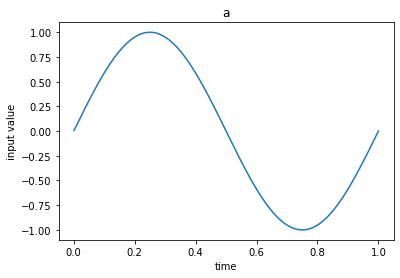

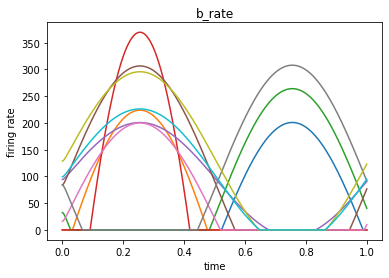

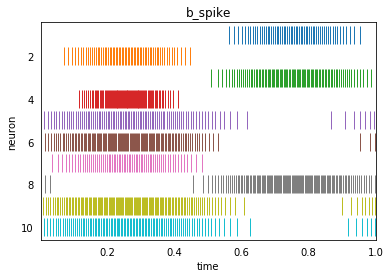

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    
    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(
        10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)
    
    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(
        10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)
    
    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)
    
with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input 
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")
    
plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike");

Each neuron responds to the input signal differently due to the random parameterization in the network (e.g. connection weights and biases).  We have matched the parameterization in the rate and spiking ensembles so that it is easier to see the parallels.

Note that the same information is being represented in the two ensembles.  For example, when the second neuron (orange) is outputting a high continuous value (in the second graph), the corresponding spiking neuron is outputting more discrete spikes (orange lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic filters.  This is inspired by a biological feature where discrete spikes induce a continuous electrical waveform in the receiving neuron, at the synapse (the point where the two neurons connect).  But computationally we can think of this simply as applying a filter to the spiking signal.

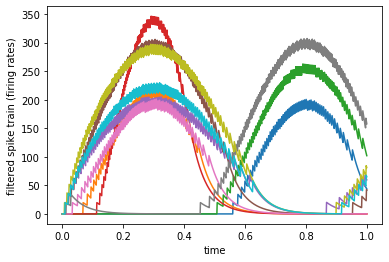

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)");

We can see how the spike trains, when viewed through a synaptic filter, approximate the continuous rate values in the second graph above.  

In this example we have computed the filtered signal manually for demonstration purposes, but in a typical Nengo model these synaptic filters are applied throughout the model, on the `Connection` objects.  For example, the above filtering would be equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and Nengo from a standard deep network background.  Although spiking neurons seem like a radically different paradigm, they can compute and communicate the same information as their rate counterparts.  But note that this only makes sense when we think of the network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete list).  These neuron models have various different behaviours, and managing their parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly work together.  Thus one important feature is the ability to write TensorFlow code directly, and insert it into a Nengo network.  This allows us to use whichever framework is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the rest of a Nengo model.  The TensorFlow code is written in a function that takes `tf.Tensors` as input, applies the desired manipulations through TensorFlow operations, and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose we want to apply batch normalization to the output of one of the Nengo ensembles.  There is no built-in way to do batch normalization in Nengo, so we can instead turn to TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(
        tf.keras.layers.BatchNormalization(momentum=0.9))(b_rate.neurons)
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`, except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this case, and we can add Probes or Connections to `batch_norm` in the same way as any other Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and `Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9), 
        shape_in=(10,), pass_time=False)
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the current simulation time and `x` is the value of any Connections incoming to the TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the `TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The `TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,) + shape_out`, where `shape_out` is the output dimensionality of the node (dependent on the manipulations applied to the inputs `x`).  We could explicitly specify `shape_out=(10,)` in the above example, or if we don't specify the output shape it will be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1]) 
    
    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)
        
        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)
        
    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), 
                            shape_out=(2,))
    nengo.Connection(a, b, synapse=None)
    
    p = nengo.Probe(b)
    
with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

TensorNode input:


t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation time over the 10 timesteps we executed, and `x` contains the value of the input Node that we connected to the TensorNode.  And we can see in the probe data that the TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This can be useful, for example, if the TensorNode requires internal parameters (which should be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:
    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))
        
        def call(self, inputs):
            return inputs * self.w
            
    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), 
                            pass_time=False)

More details on TensorNode usage can be found in [the user guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms, through the `Simulator.fit` function.  Returning to the autoencoder examples from the beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Train on 60000 samples
Epoch 1/2


   32/60000 [..............................] - ETA: 6:45 - loss: 7529.1123

  832/60000 [..............................] - ETA: 19s - loss: 4433.9443 

 1632/60000 [..............................] - ETA: 11s - loss: 3803.9884

 2400/60000 [>.............................] - ETA: 8s - loss: 3428.3074 

 3264/60000 [>.............................] - ETA: 7s - loss: 3141.2387

 4000/60000 [=>............................] - ETA: 6s - loss: 2954.6407

 4800/60000 [=>............................] - ETA: 6s - loss: 2791.2281

 5664/60000 [=>............................] - ETA: 5s - loss: 2637.9048

 6496/60000 [==>...........................] - ETA: 5s - loss: 2515.0605

 7232/60000 [==>...........................] - ETA: 4s - loss: 2424.3857

 8160/60000 [===>..........................] - ETA: 4s - loss: 2323.9573

 8992/60000 [===>..........................] - ETA: 4s - loss: 2246.2336

 9920/60000 [===>..........................] - ETA: 4s - loss: 2168.4457

10784/60000 [====>.........................] - ETA: 4s - loss: 2105.6017

11648/60000 [====>.........................] - ETA: 3s - loss: 2048.8669

12544/60000 [=====>........................] - ETA: 3s - loss: 1996.1749

13440/60000 [=====>........................] - ETA: 3s - loss: 1950.7905

14208/60000 [======>.......................] - ETA: 3s - loss: 1912.0165

15008/60000 [======>.......................] - ETA: 3s - loss: 1875.1418

15872/60000 [======>.......................] - ETA: 3s - loss: 1838.4795

16640/60000 [=======>......................] - ETA: 3s - loss: 1809.9938

17408/60000 [=======>......................] - ETA: 3s - loss: 1782.9848

18240/60000 [========>.....................] - ETA: 3s - loss: 1753.2118

19008/60000 [========>.....................] - ETA: 3s - loss: 1728.4514

19744/60000 [========>.....................] - ETA: 2s - loss: 1706.7188

20480/60000 [=========>....................] - ETA: 2s - loss: 1687.2206

21280/60000 [=========>....................] - ETA: 2s - loss: 1664.3276

21984/60000 [=========>....................] - ETA: 2s - loss: 1645.9448

22752/60000 [==========>...................] - ETA: 2s - loss: 1628.1600

23424/60000 [==========>...................] - ETA: 2s - loss: 1613.7438

24224/60000 [===========>..................] - ETA: 2s - loss: 1595.7687

24896/60000 [===========>..................] - ETA: 2s - loss: 1582.2544

25664/60000 [===========>..................] - ETA: 2s - loss: 1566.5127

26464/60000 [============>.................] - ETA: 2s - loss: 1551.1215

27328/60000 [============>.................] - ETA: 2s - loss: 1535.5640

28064/60000 [=============>................] - ETA: 2s - loss: 1522.7108

28928/60000 [=============>................] - ETA: 2s - loss: 1509.2472

29888/60000 [=============>................] - ETA: 2s - loss: 1493.8814

30656/60000 [==============>...............] - ETA: 2s - loss: 1482.1577

31360/60000 [==============>...............] - ETA: 2s - loss: 1472.0553

32096/60000 [===============>..............] - ETA: 1s - loss: 1461.4615

32896/60000 [===============>..............] - ETA: 1s - loss: 1450.2737

33568/60000 [===============>..............] - ETA: 1s - loss: 1441.5900

34400/60000 [================>.............] - ETA: 1s - loss: 1430.8320

35136/60000 [================>.............] - ETA: 1s - loss: 1421.9122

36000/60000 [=================>............] - ETA: 1s - loss: 1411.5210

36672/60000 [=================>............] - ETA: 1s - loss: 1403.9479

37440/60000 [=================>............] - ETA: 1s - loss: 1395.3361

38240/60000 [==================>...........] - ETA: 1s - loss: 1386.2886

39008/60000 [==================>...........] - ETA: 1s - loss: 1378.1519

39840/60000 [==================>...........] - ETA: 1s - loss: 1369.2586

40640/60000 [===================>..........] - ETA: 1s - loss: 1361.2720

41440/60000 [===================>..........] - ETA: 1s - loss: 1353.3852

42272/60000 [====================>.........] - ETA: 1s - loss: 1345.3829

43104/60000 [====================>.........] - ETA: 1s - loss: 1337.9941

44064/60000 [=====================>........] - ETA: 1s - loss: 1329.4949

44960/60000 [=====================>........] - ETA: 1s - loss: 1321.8061

45824/60000 [=====================>........] - ETA: 0s - loss: 1315.1884

46688/60000 [======================>.......] - ETA: 0s - loss: 1309.1431

47488/60000 [======================>.......] - ETA: 0s - loss: 1302.8477

48224/60000 [=======================>......] - ETA: 0s - loss: 1297.0427

49024/60000 [=======================>......] - ETA: 0s - loss: 1291.0090

49856/60000 [=======================>......] - ETA: 0s - loss: 1284.3481

50688/60000 [========================>.....] - ETA: 0s - loss: 1278.3564

51488/60000 [========================>.....] - ETA: 0s - loss: 1272.8114

52352/60000 [=========================>....] - ETA: 0s - loss: 1267.0730

53152/60000 [=========================>....] - ETA: 0s - loss: 1261.8878

53920/60000 [=========================>....] - ETA: 0s - loss: 1256.7655

54656/60000 [==========================>...] - ETA: 0s - loss: 1251.9779

55392/60000 [==========================>...] - ETA: 0s - loss: 1247.5347

56224/60000 [===========================>..] - ETA: 0s - loss: 1242.3325

57056/60000 [===========================>..] - ETA: 0s - loss: 1237.5309

57792/60000 [===========================>..] - ETA: 0s - loss: 1233.0946

58464/60000 [============================>.] - ETA: 0s - loss: 1229.2589

59232/60000 [============================>.] - ETA: 0s - loss: 1224.7820

59968/60000 [============================>.] - ETA: 0s - loss: 1221.2312

60000/60000 [==============================] - 4s 67us/sample - loss: 1221.0640


Epoch 2/2
   32/60000 [..............................] - ETA: 3s - loss: 839.8111

  672/60000 [..............................] - ETA: 4s - loss: 885.9628

 1408/60000 [..............................] - ETA: 4s - loss: 877.8267

 2080/60000 [>.............................] - ETA: 4s - loss: 877.8111

 2720/60000 [>.............................] - ETA: 4s - loss: 886.3685

 3328/60000 [>.............................] - ETA: 4s - loss: 888.3455

 4032/60000 [=>............................] - ETA: 4s - loss: 885.3245

 4640/60000 [=>............................] - ETA: 4s - loss: 889.0538

 5280/60000 [=>............................] - ETA: 4s - loss: 886.8851

 5952/60000 [=>............................] - ETA: 4s - loss: 888.6665

 6592/60000 [==>...........................] - ETA: 4s - loss: 889.1572

 7232/60000 [==>...........................] - ETA: 4s - loss: 886.8658

 7968/60000 [==>...........................] - ETA: 4s - loss: 887.3463

 8672/60000 [===>..........................] - ETA: 3s - loss: 886.9512

 9344/60000 [===>..........................] - ETA: 3s - loss: 887.1699

10016/60000 [====>.........................] - ETA: 3s - loss: 887.5291

10752/60000 [====>.........................] - ETA: 3s - loss: 888.6066

11520/60000 [====>.........................] - ETA: 3s - loss: 889.6831

12160/60000 [=====>........................] - ETA: 3s - loss: 889.2531

12832/60000 [=====>........................] - ETA: 3s - loss: 888.2834

13536/60000 [=====>........................] - ETA: 3s - loss: 887.7084

14144/60000 [======>.......................] - ETA: 3s - loss: 886.2775

14848/60000 [======>.......................] - ETA: 3s - loss: 886.8107

15584/60000 [======>.......................] - ETA: 3s - loss: 887.2720

16320/60000 [=======>......................] - ETA: 3s - loss: 886.6347

17056/60000 [=======>......................] - ETA: 3s - loss: 885.8380

17728/60000 [=======>......................] - ETA: 3s - loss: 885.9501

18400/60000 [========>.....................] - ETA: 3s - loss: 884.9701

19136/60000 [========>.....................] - ETA: 3s - loss: 884.7075

19776/60000 [========>.....................] - ETA: 3s - loss: 884.6729

20480/60000 [=========>....................] - ETA: 2s - loss: 884.8003

21152/60000 [=========>....................] - ETA: 2s - loss: 885.0371

21728/60000 [=========>....................] - ETA: 2s - loss: 884.7759

22432/60000 [==========>...................] - ETA: 2s - loss: 884.7218

23072/60000 [==========>...................] - ETA: 2s - loss: 883.3776

23680/60000 [==========>...................] - ETA: 2s - loss: 883.1044

24416/60000 [===========>..................] - ETA: 2s - loss: 882.7590

25120/60000 [===========>..................] - ETA: 2s - loss: 882.4094

25760/60000 [===========>..................] - ETA: 2s - loss: 882.4164

26368/60000 [============>.................] - ETA: 2s - loss: 882.3038

27072/60000 [============>.................] - ETA: 2s - loss: 881.9459

27712/60000 [============>.................] - ETA: 2s - loss: 881.9721

28320/60000 [=============>................] - ETA: 2s - loss: 882.2879

28960/60000 [=============>................] - ETA: 2s - loss: 881.5241

29632/60000 [=============>................] - ETA: 2s - loss: 881.6783

30240/60000 [==============>...............] - ETA: 2s - loss: 881.1209

30880/60000 [==============>...............] - ETA: 2s - loss: 880.7450

31552/60000 [==============>...............] - ETA: 2s - loss: 880.4022

32224/60000 [===============>..............] - ETA: 2s - loss: 879.9776

32928/60000 [===============>..............] - ETA: 2s - loss: 880.2913

33568/60000 [===============>..............] - ETA: 2s - loss: 880.2188

34240/60000 [================>.............] - ETA: 1s - loss: 879.6305

34848/60000 [================>.............] - ETA: 1s - loss: 878.9006

35488/60000 [================>.............] - ETA: 1s - loss: 878.7643

36160/60000 [=================>............] - ETA: 1s - loss: 878.3123

36800/60000 [=================>............] - ETA: 1s - loss: 878.9641

37440/60000 [=================>............] - ETA: 1s - loss: 878.7979

38080/60000 [==================>...........] - ETA: 1s - loss: 877.8991

38752/60000 [==================>...........] - ETA: 1s - loss: 877.4211

39424/60000 [==================>...........] - ETA: 1s - loss: 877.5353

40032/60000 [===================>..........] - ETA: 1s - loss: 877.4153

40672/60000 [===================>..........] - ETA: 1s - loss: 877.5830

41344/60000 [===================>..........] - ETA: 1s - loss: 877.4224

42016/60000 [====================>.........] - ETA: 1s - loss: 877.2340

42720/60000 [====================>.........] - ETA: 1s - loss: 876.9075

43328/60000 [====================>.........] - ETA: 1s - loss: 876.9126

43968/60000 [====================>.........] - ETA: 1s - loss: 877.0673

44640/60000 [=====================>........] - ETA: 1s - loss: 876.9717

45280/60000 [=====================>........] - ETA: 1s - loss: 876.7336

45952/60000 [=====================>........] - ETA: 1s - loss: 876.5811

46656/60000 [======================>.......] - ETA: 1s - loss: 876.2036

47328/60000 [======================>.......] - ETA: 0s - loss: 875.6973

47968/60000 [======================>.......] - ETA: 0s - loss: 875.5116

48576/60000 [=======================>......] - ETA: 0s - loss: 875.7133

49216/60000 [=======================>......] - ETA: 0s - loss: 875.4075

49888/60000 [=======================>......] - ETA: 0s - loss: 875.0581

50560/60000 [========================>.....] - ETA: 0s - loss: 874.3805

51264/60000 [========================>.....] - ETA: 0s - loss: 873.9048

51904/60000 [========================>.....] - ETA: 0s - loss: 873.4898

52576/60000 [=========================>....] - ETA: 0s - loss: 873.5261

53280/60000 [=========================>....] - ETA: 0s - loss: 873.0519

53920/60000 [=========================>....] - ETA: 0s - loss: 872.4372

54624/60000 [==========================>...] - ETA: 0s - loss: 871.9301

55360/60000 [==========================>...] - ETA: 0s - loss: 871.6307

56032/60000 [===========================>..] - ETA: 0s - loss: 871.3305

56736/60000 [===========================>..] - ETA: 0s - loss: 871.6985

57376/60000 [===========================>..] - ETA: 0s - loss: 871.3821

58048/60000 [============================>.] - ETA: 0s - loss: 870.8856

58752/60000 [============================>.] - ETA: 0s - loss: 870.5959

59424/60000 [============================>.] - ETA: 0s - loss: 870.1061

60000/60000 [==============================] - 5s 77us/sample - loss: 869.6211


10000/10000 - 1s - loss: 856.8393


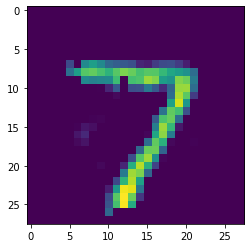

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
              loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
model.evaluate(test_data, test_data, verbose=2)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)));

Before running the same training in NengoDL, we'll change the Nengo model parameters to more closely match the TensorFlow network (we omitted these details in the original presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are essentially temporal, so data is described over time (indicating what the inputs/targets should be on each simulation timestep).  So instead of the data having shape `(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll just be training for a single timestep, but we still need to add that extra axis with length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

Train on 60000 samples
Epoch 1/2


   50/60000 [..............................] - ETA: 5:56 - loss: 7040.9062 - probe_loss: 7040.9062

  500/60000 [..............................] - ETA: 42s - loss: 5145.3373 - probe_loss: 5145.3369 

  900/60000 [..............................] - ETA: 26s - loss: 4671.6158 - probe_loss: 4671.6157

 1300/60000 [..............................] - ETA: 20s - loss: 4346.6432 - probe_loss: 4346.6431

 1650/60000 [..............................] - ETA: 18s - loss: 4108.4371 - probe_loss: 4108.4370

 2000/60000 [>.............................] - ETA: 16s - loss: 3925.3955 - probe_loss: 3925.3958

 2400/60000 [>.............................] - ETA: 14s - loss: 3734.1512 - probe_loss: 3734.1511

 2750/60000 [>.............................] - ETA: 13s - loss: 3592.6501 - probe_loss: 3592.6497

 3150/60000 [>.............................] - ETA: 12s - loss: 3456.9525 - probe_loss: 3456.9521

 3550/60000 [>.............................] - ETA: 12s - loss: 3335.7216 - probe_loss: 3335.7212

 3950/60000 [>.............................] - ETA: 11s - loss: 3221.7899 - probe_loss: 3221.7893

 4350/60000 [=>............................] - ETA: 11s - loss: 3130.2913 - probe_loss: 3130.2905

 4800/60000 [=>............................] - ETA: 10s - loss: 3031.6002 - probe_loss: 3031.5994

 5200/60000 [=>............................] - ETA: 10s - loss: 2963.5254 - probe_loss: 2963.5244

 5550/60000 [=>............................] - ETA: 10s - loss: 2898.0814 - probe_loss: 2898.0798

 5900/60000 [=>............................] - ETA: 9s - loss: 2844.0964 - probe_loss: 2844.0950 

 6250/60000 [==>...........................] - ETA: 9s - loss: 2795.5583 - probe_loss: 2795.5566

 6650/60000 [==>...........................] - ETA: 9s - loss: 2741.3395 - probe_loss: 2741.3381

 7000/60000 [==>...........................] - ETA: 9s - loss: 2696.4306 - probe_loss: 2696.4292

 7400/60000 [==>...........................] - ETA: 9s - loss: 2652.4333 - probe_loss: 2652.4321

 7800/60000 [==>...........................] - ETA: 9s - loss: 2611.4248 - probe_loss: 2611.4238

 8200/60000 [===>..........................] - ETA: 8s - loss: 2565.9990 - probe_loss: 2565.9980

 8600/60000 [===>..........................] - ETA: 8s - loss: 2525.7469 - probe_loss: 2525.7458

 9000/60000 [===>..........................] - ETA: 8s - loss: 2489.3853 - probe_loss: 2489.3843

 9400/60000 [===>..........................] - ETA: 8s - loss: 2454.1632 - probe_loss: 2454.1624

 9750/60000 [===>..........................] - ETA: 8s - loss: 2423.5776 - probe_loss: 2423.5767

10100/60000 [====>.........................] - ETA: 8s - loss: 2395.0144 - probe_loss: 2395.0137

10450/60000 [====>.........................] - ETA: 8s - loss: 2369.5701 - probe_loss: 2369.5693

10800/60000 [====>.........................] - ETA: 8s - loss: 2342.8913 - probe_loss: 2342.8906

11200/60000 [====>.........................] - ETA: 7s - loss: 2316.1928 - probe_loss: 2316.1919

11600/60000 [====>.........................] - ETA: 7s - loss: 2287.9874 - probe_loss: 2287.9866

12000/60000 [=====>........................] - ETA: 7s - loss: 2263.5157 - probe_loss: 2263.5149

12400/60000 [=====>........................] - ETA: 7s - loss: 2238.1195 - probe_loss: 2238.1189

12800/60000 [=====>........................] - ETA: 7s - loss: 2214.2704 - probe_loss: 2214.2698

13200/60000 [=====>........................] - ETA: 7s - loss: 2191.0478 - probe_loss: 2191.0471

13650/60000 [=====>........................] - ETA: 7s - loss: 2167.6897 - probe_loss: 2167.6892

14000/60000 [======>.......................] - ETA: 7s - loss: 2150.7577 - probe_loss: 2150.7571

14400/60000 [======>.......................] - ETA: 7s - loss: 2129.5259 - probe_loss: 2129.5256

14800/60000 [======>.......................] - ETA: 7s - loss: 2109.7885 - probe_loss: 2109.7881

15150/60000 [======>.......................] - ETA: 6s - loss: 2091.9790 - probe_loss: 2091.9788

15550/60000 [======>.......................] - ETA: 6s - loss: 2072.5419 - probe_loss: 2072.5415

15950/60000 [======>.......................] - ETA: 6s - loss: 2055.1534 - probe_loss: 2055.1531

16350/60000 [=======>......................] - ETA: 6s - loss: 2038.3825 - probe_loss: 2038.3821

16750/60000 [=======>......................] - ETA: 6s - loss: 2021.2140 - probe_loss: 2021.2140

17150/60000 [=======>......................] - ETA: 6s - loss: 2005.5751 - probe_loss: 2005.5751

17550/60000 [=======>......................] - ETA: 6s - loss: 1990.1707 - probe_loss: 1990.1708

17900/60000 [=======>......................] - ETA: 6s - loss: 1976.9943 - probe_loss: 1976.9943

18250/60000 [========>.....................] - ETA: 6s - loss: 1963.3883 - probe_loss: 1963.3882

18650/60000 [========>.....................] - ETA: 6s - loss: 1948.2645 - probe_loss: 1948.2644

19050/60000 [========>.....................] - ETA: 6s - loss: 1935.0773 - probe_loss: 1935.0773

19400/60000 [========>.....................] - ETA: 6s - loss: 1923.3670 - probe_loss: 1923.3671

19800/60000 [========>.....................] - ETA: 6s - loss: 1909.7707 - probe_loss: 1909.7706

20200/60000 [=========>....................] - ETA: 6s - loss: 1897.6695 - probe_loss: 1897.6696

20600/60000 [=========>....................] - ETA: 5s - loss: 1884.9776 - probe_loss: 1884.9777

21000/60000 [=========>....................] - ETA: 5s - loss: 1872.6684 - probe_loss: 1872.6685

21400/60000 [=========>....................] - ETA: 5s - loss: 1861.6125 - probe_loss: 1861.6124

21800/60000 [=========>....................] - ETA: 5s - loss: 1851.1631 - probe_loss: 1851.1631

22200/60000 [==========>...................] - ETA: 5s - loss: 1839.7368 - probe_loss: 1839.7369

22600/60000 [==========>...................] - ETA: 5s - loss: 1828.6551 - probe_loss: 1828.6550

23000/60000 [==========>...................] - ETA: 5s - loss: 1818.5155 - probe_loss: 1818.5154

23400/60000 [==========>...................] - ETA: 5s - loss: 1807.9286 - probe_loss: 1807.9285

23800/60000 [==========>...................] - ETA: 5s - loss: 1797.5102 - probe_loss: 1797.5099

24200/60000 [===========>..................] - ETA: 5s - loss: 1788.0552 - probe_loss: 1788.0548

24600/60000 [===========>..................] - ETA: 5s - loss: 1779.1362 - probe_loss: 1779.1356

25000/60000 [===========>..................] - ETA: 5s - loss: 1770.2199 - probe_loss: 1770.2194

25450/60000 [===========>..................] - ETA: 5s - loss: 1760.1489 - probe_loss: 1760.1482

25850/60000 [===========>..................] - ETA: 5s - loss: 1751.5898 - probe_loss: 1751.5892

26250/60000 [============>.................] - ETA: 4s - loss: 1743.3712 - probe_loss: 1743.3706

26700/60000 [============>.................] - ETA: 4s - loss: 1732.8317 - probe_loss: 1732.8309

27200/60000 [============>.................] - ETA: 4s - loss: 1722.3413 - probe_loss: 1722.3408

27600/60000 [============>.................] - ETA: 4s - loss: 1715.1211 - probe_loss: 1715.1206

27900/60000 [============>.................] - ETA: 4s - loss: 1708.7545 - probe_loss: 1708.7539

28250/60000 [=============>................] - ETA: 4s - loss: 1701.6175 - probe_loss: 1701.6171

28800/60000 [=============>................] - ETA: 4s - loss: 1691.1541 - probe_loss: 1691.1536

29250/60000 [=============>................] - ETA: 4s - loss: 1683.1610 - probe_loss: 1683.1605

29700/60000 [=============>................] - ETA: 4s - loss: 1674.8517 - probe_loss: 1674.8512

30100/60000 [==============>...............] - ETA: 4s - loss: 1667.4637 - probe_loss: 1667.4631

30550/60000 [==============>...............] - ETA: 4s - loss: 1659.5131 - probe_loss: 1659.5127

31000/60000 [==============>...............] - ETA: 4s - loss: 1652.3129 - probe_loss: 1652.3126

31400/60000 [==============>...............] - ETA: 4s - loss: 1645.6840 - probe_loss: 1645.6837

31750/60000 [==============>...............] - ETA: 4s - loss: 1639.9543 - probe_loss: 1639.9540

32200/60000 [===============>..............] - ETA: 3s - loss: 1632.3391 - probe_loss: 1632.3389

32600/60000 [===============>..............] - ETA: 3s - loss: 1625.5314 - probe_loss: 1625.5310

33050/60000 [===============>..............] - ETA: 3s - loss: 1619.1569 - probe_loss: 1619.1567

33450/60000 [===============>..............] - ETA: 3s - loss: 1612.7493 - probe_loss: 1612.7490

33850/60000 [===============>..............] - ETA: 3s - loss: 1606.4190 - probe_loss: 1606.4187

34250/60000 [================>.............] - ETA: 3s - loss: 1600.5741 - probe_loss: 1600.5737

34700/60000 [================>.............] - ETA: 3s - loss: 1594.0074 - probe_loss: 1594.0071

35100/60000 [================>.............] - ETA: 3s - loss: 1587.8122 - probe_loss: 1587.8118

35550/60000 [================>.............] - ETA: 3s - loss: 1581.5647 - probe_loss: 1581.5643

36000/60000 [=================>............] - ETA: 3s - loss: 1575.2091 - probe_loss: 1575.2089

36400/60000 [=================>............] - ETA: 3s - loss: 1569.6390 - probe_loss: 1569.6385

36800/60000 [=================>............] - ETA: 3s - loss: 1564.4458 - probe_loss: 1564.4454

37200/60000 [=================>............] - ETA: 3s - loss: 1559.1817 - probe_loss: 1559.1814

37550/60000 [=================>............] - ETA: 3s - loss: 1554.8878 - probe_loss: 1554.8877

37900/60000 [=================>............] - ETA: 3s - loss: 1550.5898 - probe_loss: 1550.5896

38300/60000 [==================>...........] - ETA: 3s - loss: 1545.0425 - probe_loss: 1545.0421

38700/60000 [==================>...........] - ETA: 3s - loss: 1540.5101 - probe_loss: 1540.5096

39100/60000 [==================>...........] - ETA: 2s - loss: 1536.0078 - probe_loss: 1536.0073

39450/60000 [==================>...........] - ETA: 2s - loss: 1531.5174 - probe_loss: 1531.5170

39850/60000 [==================>...........] - ETA: 2s - loss: 1526.4781 - probe_loss: 1526.4778

40250/60000 [===================>..........] - ETA: 2s - loss: 1521.6149 - probe_loss: 1521.6146

40600/60000 [===================>..........] - ETA: 2s - loss: 1517.5108 - probe_loss: 1517.5105

40950/60000 [===================>..........] - ETA: 2s - loss: 1513.1742 - probe_loss: 1513.1740

41350/60000 [===================>..........] - ETA: 2s - loss: 1509.1735 - probe_loss: 1509.1735

41700/60000 [===================>..........] - ETA: 2s - loss: 1505.1729 - probe_loss: 1505.1730

42100/60000 [====================>.........] - ETA: 2s - loss: 1500.7909 - probe_loss: 1500.7908

42450/60000 [====================>.........] - ETA: 2s - loss: 1496.8701 - probe_loss: 1496.8700

42800/60000 [====================>.........] - ETA: 2s - loss: 1493.6826 - probe_loss: 1493.6825

43150/60000 [====================>.........] - ETA: 2s - loss: 1490.0297 - probe_loss: 1490.0297

43550/60000 [====================>.........] - ETA: 2s - loss: 1485.9877 - probe_loss: 1485.9877

43950/60000 [====================>.........] - ETA: 2s - loss: 1481.6443 - probe_loss: 1481.6442

44350/60000 [=====================>........] - ETA: 2s - loss: 1477.6970 - probe_loss: 1477.6969

44700/60000 [=====================>........] - ETA: 2s - loss: 1474.0618 - probe_loss: 1474.0618

45050/60000 [=====================>........] - ETA: 2s - loss: 1470.3363 - probe_loss: 1470.3363

45450/60000 [=====================>........] - ETA: 2s - loss: 1466.2750 - probe_loss: 1466.2751

45800/60000 [=====================>........] - ETA: 2s - loss: 1463.2801 - probe_loss: 1463.2804

46150/60000 [======================>.......] - ETA: 1s - loss: 1459.5415 - probe_loss: 1459.5416

46500/60000 [======================>.......] - ETA: 1s - loss: 1456.1334 - probe_loss: 1456.1334

46850/60000 [======================>.......] - ETA: 1s - loss: 1452.8870 - probe_loss: 1452.8873

47250/60000 [======================>.......] - ETA: 1s - loss: 1449.5802 - probe_loss: 1449.5806

47650/60000 [======================>.......] - ETA: 1s - loss: 1445.8189 - probe_loss: 1445.8191

48050/60000 [=======================>......] - ETA: 1s - loss: 1442.2271 - probe_loss: 1442.2275

48450/60000 [=======================>......] - ETA: 1s - loss: 1438.2422 - probe_loss: 1438.2427

48850/60000 [=======================>......] - ETA: 1s - loss: 1434.7833 - probe_loss: 1434.7839

49200/60000 [=======================>......] - ETA: 1s - loss: 1432.0161 - probe_loss: 1432.0166

49600/60000 [=======================>......] - ETA: 1s - loss: 1428.7096 - probe_loss: 1428.7101

49950/60000 [=======================>......] - ETA: 1s - loss: 1425.6799 - probe_loss: 1425.6804

50350/60000 [========================>.....] - ETA: 1s - loss: 1422.2432 - probe_loss: 1422.2435

50700/60000 [========================>.....] - ETA: 1s - loss: 1419.2899 - probe_loss: 1419.2903

51100/60000 [========================>.....] - ETA: 1s - loss: 1416.1694 - probe_loss: 1416.1699

51500/60000 [========================>.....] - ETA: 1s - loss: 1413.1850 - probe_loss: 1413.1853

51900/60000 [========================>.....] - ETA: 1s - loss: 1409.8936 - probe_loss: 1409.8940

52250/60000 [=========================>....] - ETA: 1s - loss: 1407.2517 - probe_loss: 1407.2523

52650/60000 [=========================>....] - ETA: 1s - loss: 1403.8719 - probe_loss: 1403.8723

53050/60000 [=========================>....] - ETA: 0s - loss: 1400.8728 - probe_loss: 1400.8732

53400/60000 [=========================>....] - ETA: 0s - loss: 1398.3093 - probe_loss: 1398.3096

53750/60000 [=========================>....] - ETA: 0s - loss: 1396.0228 - probe_loss: 1396.0232

54150/60000 [==========================>...] - ETA: 0s - loss: 1392.9511 - probe_loss: 1392.9515

54550/60000 [==========================>...] - ETA: 0s - loss: 1390.0475 - probe_loss: 1390.0479

54950/60000 [==========================>...] - ETA: 0s - loss: 1387.4555 - probe_loss: 1387.4558

55300/60000 [==========================>...] - ETA: 0s - loss: 1385.2482 - probe_loss: 1385.2485

55650/60000 [==========================>...] - ETA: 0s - loss: 1382.3453 - probe_loss: 1382.3457

56000/60000 [===========================>..] - ETA: 0s - loss: 1379.8210 - probe_loss: 1379.8214

56400/60000 [===========================>..] - ETA: 0s - loss: 1377.3553 - probe_loss: 1377.3557

56750/60000 [===========================>..] - ETA: 0s - loss: 1375.0545 - probe_loss: 1375.0548

57150/60000 [===========================>..] - ETA: 0s - loss: 1372.6503 - probe_loss: 1372.6508

57550/60000 [===========================>..] - ETA: 0s - loss: 1369.8861 - probe_loss: 1369.8865

57950/60000 [===========================>..] - ETA: 0s - loss: 1367.3294 - probe_loss: 1367.3301

58350/60000 [============================>.] - ETA: 0s - loss: 1364.7941 - probe_loss: 1364.7947

58750/60000 [============================>.] - ETA: 0s - loss: 1362.1458 - probe_loss: 1362.1464

59150/60000 [============================>.] - ETA: 0s - loss: 1359.3400 - probe_loss: 1359.3406

59550/60000 [============================>.] - ETA: 0s - loss: 1356.8511 - probe_loss: 1356.8516

59950/60000 [============================>.] - ETA: 0s - loss: 1354.5127 - probe_loss: 1354.5132

60000/60000 [==============================] - 8s 141us/sample - loss: 1354.2800 - probe_loss: 1354.2805


Epoch 2/2
   50/60000 [..............................] - ETA: 11s - loss: 886.1766 - probe_loss: 886.1766

  450/60000 [..............................] - ETA: 8s - loss: 950.3434 - probe_loss: 950.3435 

  850/60000 [..............................] - ETA: 8s - loss: 954.3505 - probe_loss: 954.3506

 1250/60000 [..............................] - ETA: 8s - loss: 958.1517 - probe_loss: 958.1516

 1650/60000 [..............................] - ETA: 8s - loss: 955.1054 - probe_loss: 955.1053

 2000/60000 [>.............................] - ETA: 8s - loss: 964.6828 - probe_loss: 964.6827

 2350/60000 [>.............................] - ETA: 8s - loss: 963.0389 - probe_loss: 963.0389

 2700/60000 [>.............................] - ETA: 8s - loss: 965.4150 - probe_loss: 965.4151

 3100/60000 [>.............................] - ETA: 8s - loss: 964.4350 - probe_loss: 964.4352

 3500/60000 [>.............................] - ETA: 7s - loss: 965.4678 - probe_loss: 965.4680

 3900/60000 [>.............................] - ETA: 7s - loss: 968.4402 - probe_loss: 968.4404

 4250/60000 [=>............................] - ETA: 7s - loss: 967.5652 - probe_loss: 967.5654

 4650/60000 [=>............................] - ETA: 7s - loss: 963.6306 - probe_loss: 963.6306

 5050/60000 [=>............................] - ETA: 7s - loss: 972.1700 - probe_loss: 972.1700

 5450/60000 [=>............................] - ETA: 7s - loss: 970.9051 - probe_loss: 970.9051

 5850/60000 [=>............................] - ETA: 7s - loss: 967.0391 - probe_loss: 967.0392

 6250/60000 [==>...........................] - ETA: 7s - loss: 966.3574 - probe_loss: 966.3575

 6600/60000 [==>...........................] - ETA: 7s - loss: 966.5247 - probe_loss: 966.5248

 7000/60000 [==>...........................] - ETA: 7s - loss: 967.6525 - probe_loss: 967.6526

 7400/60000 [==>...........................] - ETA: 7s - loss: 967.3965 - probe_loss: 967.3967

 7800/60000 [==>...........................] - ETA: 7s - loss: 966.8250 - probe_loss: 966.8250

 8200/60000 [===>..........................] - ETA: 7s - loss: 967.7195 - probe_loss: 967.7195

 8600/60000 [===>..........................] - ETA: 7s - loss: 968.6575 - probe_loss: 968.6574

 8950/60000 [===>..........................] - ETA: 7s - loss: 966.5120 - probe_loss: 966.5120

 9300/60000 [===>..........................] - ETA: 7s - loss: 966.4465 - probe_loss: 966.4465

 9700/60000 [===>..........................] - ETA: 6s - loss: 964.0403 - probe_loss: 964.0403

10050/60000 [====>.........................] - ETA: 6s - loss: 965.2692 - probe_loss: 965.2691

10450/60000 [====>.........................] - ETA: 6s - loss: 964.0328 - probe_loss: 964.0328

10850/60000 [====>.........................] - ETA: 6s - loss: 963.3848 - probe_loss: 963.3846

11200/60000 [====>.........................] - ETA: 6s - loss: 961.4637 - probe_loss: 961.4636

11550/60000 [====>.........................] - ETA: 6s - loss: 961.4626 - probe_loss: 961.4625

11950/60000 [====>.........................] - ETA: 6s - loss: 962.3213 - probe_loss: 962.3211

12350/60000 [=====>........................] - ETA: 6s - loss: 961.8107 - probe_loss: 961.8105

12700/60000 [=====>........................] - ETA: 6s - loss: 959.4808 - probe_loss: 959.4806

13100/60000 [=====>........................] - ETA: 6s - loss: 958.2475 - probe_loss: 958.2473

13500/60000 [=====>........................] - ETA: 6s - loss: 957.0734 - probe_loss: 957.0731

13900/60000 [=====>........................] - ETA: 6s - loss: 956.5756 - probe_loss: 956.5753

14250/60000 [======>.......................] - ETA: 6s - loss: 956.7876 - probe_loss: 956.7873

14650/60000 [======>.......................] - ETA: 6s - loss: 956.8743 - probe_loss: 956.8740

15050/60000 [======>.......................] - ETA: 6s - loss: 956.2424 - probe_loss: 956.2421

15400/60000 [======>.......................] - ETA: 6s - loss: 955.9834 - probe_loss: 955.9832

15800/60000 [======>.......................] - ETA: 6s - loss: 955.4071 - probe_loss: 955.4069

16150/60000 [=======>......................] - ETA: 6s - loss: 955.0569 - probe_loss: 955.0568

16550/60000 [=======>......................] - ETA: 6s - loss: 955.6227 - probe_loss: 955.6226

16900/60000 [=======>......................] - ETA: 6s - loss: 954.9179 - probe_loss: 954.9177

17250/60000 [=======>......................] - ETA: 5s - loss: 954.4828 - probe_loss: 954.4825

17600/60000 [=======>......................] - ETA: 5s - loss: 953.4670 - probe_loss: 953.4667

18000/60000 [========>.....................] - ETA: 5s - loss: 952.7062 - probe_loss: 952.7060

18400/60000 [========>.....................] - ETA: 5s - loss: 953.0868 - probe_loss: 953.0865

18800/60000 [========>.....................] - ETA: 5s - loss: 953.5848 - probe_loss: 953.5846

19200/60000 [========>.....................] - ETA: 5s - loss: 954.0878 - probe_loss: 954.0876

19550/60000 [========>.....................] - ETA: 5s - loss: 953.2393 - probe_loss: 953.2391

19950/60000 [========>.....................] - ETA: 5s - loss: 953.4297 - probe_loss: 953.4295

20300/60000 [=========>....................] - ETA: 5s - loss: 953.6610 - probe_loss: 953.6607

20650/60000 [=========>....................] - ETA: 5s - loss: 953.7331 - probe_loss: 953.7329

21000/60000 [=========>....................] - ETA: 5s - loss: 953.3957 - probe_loss: 953.3954

21400/60000 [=========>....................] - ETA: 5s - loss: 952.8835 - probe_loss: 952.8832

21750/60000 [=========>....................] - ETA: 5s - loss: 951.7036 - probe_loss: 951.7033

22150/60000 [==========>...................] - ETA: 5s - loss: 950.4965 - probe_loss: 950.4962

22550/60000 [==========>...................] - ETA: 5s - loss: 949.5521 - probe_loss: 949.5518

22950/60000 [==========>...................] - ETA: 5s - loss: 949.5308 - probe_loss: 949.5305

23350/60000 [==========>...................] - ETA: 5s - loss: 948.9940 - probe_loss: 948.9937

23750/60000 [==========>...................] - ETA: 5s - loss: 948.3758 - probe_loss: 948.3755

24150/60000 [===========>..................] - ETA: 4s - loss: 947.3589 - probe_loss: 947.3586

24600/60000 [===========>..................] - ETA: 4s - loss: 947.0578 - probe_loss: 947.0575

25000/60000 [===========>..................] - ETA: 4s - loss: 946.3326 - probe_loss: 946.3323

25400/60000 [===========>..................] - ETA: 4s - loss: 946.6732 - probe_loss: 946.6729

25800/60000 [===========>..................] - ETA: 4s - loss: 945.8770 - probe_loss: 945.8767

26200/60000 [============>.................] - ETA: 4s - loss: 945.9857 - probe_loss: 945.9855

26550/60000 [============>.................] - ETA: 4s - loss: 946.2484 - probe_loss: 946.2481

26900/60000 [============>.................] - ETA: 4s - loss: 945.8209 - probe_loss: 945.8206

27250/60000 [============>.................] - ETA: 4s - loss: 945.5929 - probe_loss: 945.5927

27600/60000 [============>.................] - ETA: 4s - loss: 945.9395 - probe_loss: 945.9393

28000/60000 [=============>................] - ETA: 4s - loss: 945.7702 - probe_loss: 945.7701

28400/60000 [=============>................] - ETA: 4s - loss: 945.3710 - probe_loss: 945.3709

28800/60000 [=============>................] - ETA: 4s - loss: 944.2351 - probe_loss: 944.2351

29200/60000 [=============>................] - ETA: 4s - loss: 944.2447 - probe_loss: 944.2446

29600/60000 [=============>................] - ETA: 4s - loss: 944.0321 - probe_loss: 944.0319

29950/60000 [=============>................] - ETA: 4s - loss: 944.1864 - probe_loss: 944.1862

30350/60000 [==============>...............] - ETA: 4s - loss: 944.1416 - probe_loss: 944.1416

30700/60000 [==============>...............] - ETA: 4s - loss: 943.3631 - probe_loss: 943.3631

31100/60000 [==============>...............] - ETA: 4s - loss: 942.9878 - probe_loss: 942.9879

31450/60000 [==============>...............] - ETA: 3s - loss: 941.8170 - probe_loss: 941.8172

31850/60000 [==============>...............] - ETA: 3s - loss: 941.1911 - probe_loss: 941.1913

32250/60000 [===============>..............] - ETA: 3s - loss: 940.8819 - probe_loss: 940.8820

32650/60000 [===============>..............] - ETA: 3s - loss: 940.7699 - probe_loss: 940.7700

33050/60000 [===============>..............] - ETA: 3s - loss: 939.9220 - probe_loss: 939.9220

33450/60000 [===============>..............] - ETA: 3s - loss: 939.7943 - probe_loss: 939.7942

33850/60000 [===============>..............] - ETA: 3s - loss: 939.5403 - probe_loss: 939.5402

34250/60000 [================>.............] - ETA: 3s - loss: 938.8440 - probe_loss: 938.8439

34650/60000 [================>.............] - ETA: 3s - loss: 938.0454 - probe_loss: 938.0453

35050/60000 [================>.............] - ETA: 3s - loss: 937.4139 - probe_loss: 937.4138

35450/60000 [================>.............] - ETA: 3s - loss: 937.5919 - probe_loss: 937.5919

35850/60000 [================>.............] - ETA: 3s - loss: 937.3043 - probe_loss: 937.3042

36200/60000 [=================>............] - ETA: 3s - loss: 936.9295 - probe_loss: 936.9294

36600/60000 [=================>............] - ETA: 3s - loss: 936.5363 - probe_loss: 936.5362

37000/60000 [=================>............] - ETA: 3s - loss: 935.8362 - probe_loss: 935.8361

37400/60000 [=================>............] - ETA: 3s - loss: 935.8731 - probe_loss: 935.8730

37800/60000 [=================>............] - ETA: 3s - loss: 935.5478 - probe_loss: 935.5476

38200/60000 [==================>...........] - ETA: 3s - loss: 935.2877 - probe_loss: 935.2875

38600/60000 [==================>...........] - ETA: 2s - loss: 935.0260 - probe_loss: 935.0261

38950/60000 [==================>...........] - ETA: 2s - loss: 935.1914 - probe_loss: 935.1915

39350/60000 [==================>...........] - ETA: 2s - loss: 935.0648 - probe_loss: 935.0651

39700/60000 [==================>...........] - ETA: 2s - loss: 934.5681 - probe_loss: 934.5682

40050/60000 [===================>..........] - ETA: 2s - loss: 933.9609 - probe_loss: 933.9612

40400/60000 [===================>..........] - ETA: 2s - loss: 933.1655 - probe_loss: 933.1657

40800/60000 [===================>..........] - ETA: 2s - loss: 932.8115 - probe_loss: 932.8116

41200/60000 [===================>..........] - ETA: 2s - loss: 932.5134 - probe_loss: 932.5135

41600/60000 [===================>..........] - ETA: 2s - loss: 932.7960 - probe_loss: 932.7960

41950/60000 [===================>..........] - ETA: 2s - loss: 932.5967 - probe_loss: 932.5967

42300/60000 [====================>.........] - ETA: 2s - loss: 932.5602 - probe_loss: 932.5602

42650/60000 [====================>.........] - ETA: 2s - loss: 932.4920 - probe_loss: 932.4921

43050/60000 [====================>.........] - ETA: 2s - loss: 932.1198 - probe_loss: 932.1199

43450/60000 [====================>.........] - ETA: 2s - loss: 932.0244 - probe_loss: 932.0245

43850/60000 [====================>.........] - ETA: 2s - loss: 931.8166 - probe_loss: 931.8167

44200/60000 [=====================>........] - ETA: 2s - loss: 932.0389 - probe_loss: 932.0392

44600/60000 [=====================>........] - ETA: 2s - loss: 931.4793 - probe_loss: 931.4796

45000/60000 [=====================>........] - ETA: 2s - loss: 931.1360 - probe_loss: 931.1363

45450/60000 [=====================>........] - ETA: 2s - loss: 931.4288 - probe_loss: 931.4291

45900/60000 [=====================>........] - ETA: 1s - loss: 931.2848 - probe_loss: 931.2849

46300/60000 [======================>.......] - ETA: 1s - loss: 930.9752 - probe_loss: 930.9752

46650/60000 [======================>.......] - ETA: 1s - loss: 930.6257 - probe_loss: 930.6259

47050/60000 [======================>.......] - ETA: 1s - loss: 930.5910 - probe_loss: 930.5912

47450/60000 [======================>.......] - ETA: 1s - loss: 929.7449 - probe_loss: 929.7451

47850/60000 [======================>.......] - ETA: 1s - loss: 929.6956 - probe_loss: 929.6958

48200/60000 [=======================>......] - ETA: 1s - loss: 929.5055 - probe_loss: 929.5057

48600/60000 [=======================>......] - ETA: 1s - loss: 928.9066 - probe_loss: 928.9067

49000/60000 [=======================>......] - ETA: 1s - loss: 928.7854 - probe_loss: 928.7856

49350/60000 [=======================>......] - ETA: 1s - loss: 928.8011 - probe_loss: 928.8011

49700/60000 [=======================>......] - ETA: 1s - loss: 928.5012 - probe_loss: 928.5013

50100/60000 [========================>.....] - ETA: 1s - loss: 928.6608 - probe_loss: 928.6609

50500/60000 [========================>.....] - ETA: 1s - loss: 927.8907 - probe_loss: 927.8909

50900/60000 [========================>.....] - ETA: 1s - loss: 927.7921 - probe_loss: 927.7922

51300/60000 [========================>.....] - ETA: 1s - loss: 927.4653 - probe_loss: 927.4654

51700/60000 [========================>.....] - ETA: 1s - loss: 927.0149 - probe_loss: 927.0151

52050/60000 [=========================>....] - ETA: 1s - loss: 926.8713 - probe_loss: 926.8714

52400/60000 [=========================>....] - ETA: 1s - loss: 926.5402 - probe_loss: 926.5402

52750/60000 [=========================>....] - ETA: 1s - loss: 926.5535 - probe_loss: 926.5535

53100/60000 [=========================>....] - ETA: 0s - loss: 926.1415 - probe_loss: 926.1415

53450/60000 [=========================>....] - ETA: 0s - loss: 925.9537 - probe_loss: 925.9538

53800/60000 [=========================>....] - ETA: 0s - loss: 925.4572 - probe_loss: 925.4573

54150/60000 [==========================>...] - ETA: 0s - loss: 925.4140 - probe_loss: 925.4141

54550/60000 [==========================>...] - ETA: 0s - loss: 925.0965 - probe_loss: 925.0966

54950/60000 [==========================>...] - ETA: 0s - loss: 924.8609 - probe_loss: 924.8610

55350/60000 [==========================>...] - ETA: 0s - loss: 924.3578 - probe_loss: 924.3579

55750/60000 [==========================>...] - ETA: 0s - loss: 924.0754 - probe_loss: 924.0756

56150/60000 [===========================>..] - ETA: 0s - loss: 923.9138 - probe_loss: 923.9140

56550/60000 [===========================>..] - ETA: 0s - loss: 923.5524 - probe_loss: 923.5527

56900/60000 [===========================>..] - ETA: 0s - loss: 923.2902 - probe_loss: 923.2904

57250/60000 [===========================>..] - ETA: 0s - loss: 923.0330 - probe_loss: 923.0332

57650/60000 [===========================>..] - ETA: 0s - loss: 922.7879 - probe_loss: 922.7880

58050/60000 [============================>.] - ETA: 0s - loss: 922.3083 - probe_loss: 922.3085

58400/60000 [============================>.] - ETA: 0s - loss: 922.6823 - probe_loss: 922.6825

58800/60000 [============================>.] - ETA: 0s - loss: 922.3600 - probe_loss: 922.3604

59200/60000 [============================>.] - ETA: 0s - loss: 921.9812 - probe_loss: 921.9814

59550/60000 [============================>.] - ETA: 0s - loss: 921.8062 - probe_loss: 921.8063

59950/60000 [============================>.] - ETA: 0s - loss: 921.4499 - probe_loss: 921.4501

60000/60000 [==============================] - 8s 139us/sample - loss: 921.4373 - probe_loss: 921.4374


10000/10000 - 1s - loss: 897.8410 - probe_loss: 897.8410


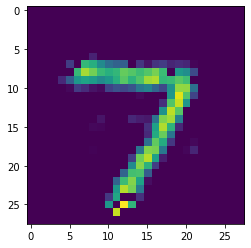

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
                loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data, verbose=2)

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)));

More details on using `sim.fit` can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering Framework (NEF).  This uses linear least-squares optimization to solve for optimal connection weights analytically, rather than using an iterative gradient-descent based algorithm.  The advantage of the NEF is that it is very fast and general (for example, it does not require the network to be differentiable).  The disadvantage is that it optimizes each set of connection weights individually (i.e., it cannot jointly optimize across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a `nengo.Connection`.  This specifies the function that we would like those connection weights to approximate.  In addition, in previous examples you may have noticed that we were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using `ensemble.neurons` specifies that we want to form a direct connection between ensemble neurons, without applying the NEF optimization.  So when we want to use the `function` argument, the `Connection` source object should be an `ensemble`, not `ensemble.neurons`.  For example, we could use the NEF to create a network to approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

|            #                Simulating                              | 0:00:01

|             #               Simulating                              | 0:00:01

|              #              Simulating                              | 0:00:01

|               #             Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

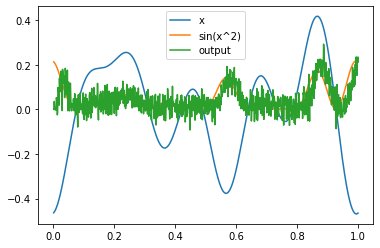

In [17]:
with nengo.Network(seed=0) as net:    
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))
    
    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)
    
    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)
    
    # output node
    outpt = nengo.Node(size_in=1)
    
    # connect input to first ensemble
    nengo.Connection(inpt, ens0)
    
    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)
    
    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)
    
    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt)
    
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

The NEF optimization can be used in combination with the deep learning optimization methods.  For example, we could optimize some parameters with the NEF and others with `sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).  Or we could initialize each set of connection weights individually with the NEF, and then further refine them with end-to-end training via `sim.fit`.  As always, the overall theme is that NengoDL allows us to use whichever method is most appropriate for a particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic networks quickly/efficiently.  However, often it is difficult to program this custom hardware, and it requires writing custom code for each neuromorphic platform.  One of the primary design goals of Nengo is to alleviate these challenges, by providing a single API that can be used to build networks across many different neuromorphic platforms.  

The idea is that the front-end network construction code is the same (`Networks`, `Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own `Simulator` class (the back-end) that compiles and executes that network definition for some compute platform.  This provides a consistent interface so that we only need to write code once and can then run that network on novel hardware platforms with no additional effort.  For example, we could take the network from above and simulate it on different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

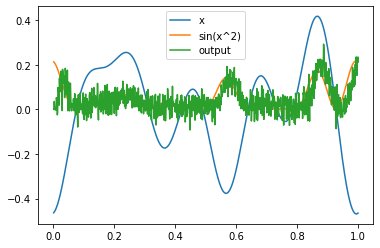

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
# run on Loihi neuromorphic hardware 
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware 
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)
    
# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

We have commented out the different backends above because they require extra installation steps, but if you are running this example yourself you can install any of those backends (or more) and uncomment that code to see the same network running on that new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end (among other things); it takes a standard Nengo network, and simulates it using TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate NengoDL's deep learning functionality into any other Nengo back-end.  We build our Network, optimize it in NengoDL, save the optimized model parameters back into the Network definition, and then simulate that optimized Network in a different back-end.  See [this example in nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL, including network construction, execution, and optimization.  We have also discussed how to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the unique features of Nengo (such as NEF optimization and neuromorphic cross-platform execution).  However, there is much more functionality in NengoDL than we are able to introduce here; check out the [user guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you would like more information on how NengoDL is implemented under the hood using TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).